In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from copy import deepcopy
import pymc as pm
import pytensor
import pytensor.tensor as tt
from pymc.gp.cov import Covariance
from functools import partial
from pytensor.tensor.linalg import cholesky, eigh, solve_triangular
from scipy.stats import multivariate_normal
solve_lower = partial(solve_triangular, lower=True)
solve_upper = partial(solve_triangular, lower=False)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
m = 40
n = 40
s = np.linspace(0, 1, m) * 4
t = np.linspace(0, 1, n) * 4
[S, T] = np.meshgrid(s, t)
SS = S.flatten()
TT = T.flatten()
N = SS.shape[0]
Xpred = np.hstack([TT.reshape(N,1), SS.reshape(N,1)])

In [3]:
np.random.seed(seed=10)
num_random_points = 7
X_init = np.array([[3, 4], 
                   [2, 1],
                   [0, 3.5], 
                   [2, 2], 
                   [3, 0], 
                   [1, 1],
                   [1.5, 3]]).reshape(num_random_points,2)
vel_x = -np.sin(X_init[:,0]) * X_init[:,1]
vel_y =  np.cos(X_init[:,0])
sigma_noise = 1e-6

In [4]:
vel_x_truth = -np.sin(Xpred[:,0]) * Xpred[:,1]
vel_y_truth = np.cos(Xpred[:,0])
vel_mag_truth = np.sqrt(vel_x_truth**2 + vel_y_truth**2)

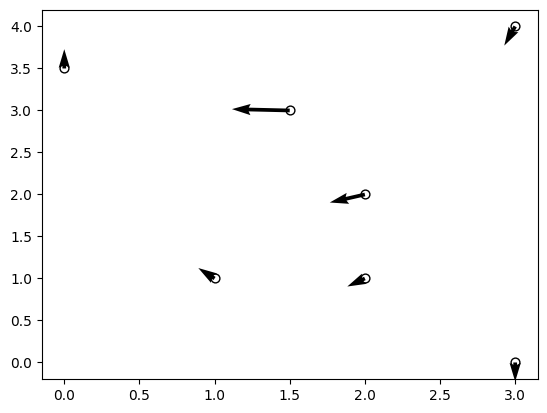

In [5]:
plt.scatter(X_init[:,0], X_init[:,1], c='w', s=40, lw=1, edgecolor='k')
plt.quiver(X_init[:,0], X_init[:,1], vel_x, vel_y)
plt.show()

In [6]:
X_init = np.vstack([X_init, X_init])
print(X_init)

[[3.  4. ]
 [2.  1. ]
 [0.  3.5]
 [2.  2. ]
 [3.  0. ]
 [1.  1. ]
 [1.5 3. ]
 [3.  4. ]
 [2.  1. ]
 [0.  3.5]
 [2.  2. ]
 [3.  0. ]
 [1.  1. ]
 [1.5 3. ]]


In [7]:
y_init = np.vstack([vel_x.reshape(num_random_points,1), vel_y.reshape(num_random_points,1)]).flatten()

In [8]:
y_init

array([-0.56448003, -0.90929743, -0.        , -1.81859485, -0.        ,
       -0.84147098, -2.99248496, -0.9899925 , -0.41614684,  1.        ,
       -0.41614684, -0.9899925 ,  0.54030231,  0.0707372 ])

### Code into pymc3 and starting with different priors, explore the MAP output!

In [9]:
class CurlFree(Covariance):
    def __init__(self, input_dim, sigma_f, l):
        super().__init__(input_dim)
        self.input_dim = input_dim
        self.sigma_f2 = tt.square(sigma_f)
        self.l2 = tt.square(l)
        
    def full(self, X, Xs=None):
        if Xs is None:
            Xs = X
        m = int(X.shape[0]/2)
        n = int(Xs.shape[0]/2)
        
        X = X[0:m,:]
        Xs = Xs[0:n,:]
        
        m2 = int( m * 2 )
        n2 = int( n * 2 )
        
        del_X = self.get_X_minus_X(X, Xs, 0)
        del_Y = self.get_X_minus_X(X, Xs, 1)
        del_X2 = tt.square(del_X)
        del_Y2 = tt.square(del_Y)
        
        K = pytensor.shared(np.zeros((m2,n2)))
        
        K = tt.set_subtensor(K[0:m, 0:n], \
                                        self.dK_xx(del_X2,del_Y2))
        
        K = tt.set_subtensor(K[m:m2, n:n2], \
                                        self.dK_yy(del_X2,del_Y2))
        
        K = tt.set_subtensor(K[0:m,n:n2], \
                                        self.dK_yx(del_X2,del_Y2, del_X, del_Y))
        
        K = tt.set_subtensor(K[m:m2,0:n], \
                                        self.dK_yx(del_X2,del_Y2, del_X, del_Y))
        
        return K
        
    def get_X_minus_X(self, X, Xs, input_dim):
        k, v = X.shape[0], Xs.shape[0]
        M = X[:,input_dim].reshape(k,1)
        Ms = Xs[:,input_dim].reshape(v,1)
        return tt.reshape(M, (-1,1)) - tt.reshape(Ms, (1,-1))
    
    def dK_xx(self, del_X2, del_Y2):
        # (sigma_f^2*exp(-(x^2 + y^2)/(2*l^2))*(l^2 - x^2))/l^4
        return (self.sigma_f2 * \
                tt.exp(-(del_X2 + del_Y2)/(2*self.l2) ) * \
                (self.l2  - del_X2))/tt.square(self.l2)
        
    def dK_yy(self, del_X2, del_Y2):
        # (sigma_f^2*exp(-(x^2 + y^2)/(2*l^2))*(l^2 - y^2))/l^4
        return (self.sigma_f2 * 
                tt.exp(-(del_X2 + del_Y2)/(2*self.l2) ) * \
                (self.l2 - del_Y2))/tt.square(self.l2)
        
    def dK_yx(self, del_X2, del_Y2, del_X, del_Y):
        # (sigma_f^2*x*y*exp(-(x^2 + y^2)/(2*l^2)))/l^4
        return  -(self.sigma_f2 * del_X * del_Y * \
                tt.exp(-(del_X2 + del_Y2)/(2*self.l2)))/tt.square(self.l2)

In [10]:
class SquaredExp(Covariance):
    def __init__(self, input_dim, sigma_f, l):
        self.input_dim = input_dim
        self.sigma_f2 = tt.square(sigma_f)
        self.l = tt.square(l)
        
    def full(self, X, Xs=None):
        if Xs is None:
            Xs = X
        return self.sigma_f2 * tt.exp(-0.5 * self.square_dist(X,Xs))

    def square_dist(self, X, Xs):
        X = tt.mul(X, self.l)
        X2 = tt.sum(tt.square(X), 1)
        if Xs is None:
            sqd = -2.0 * tt.dot(X, tt.transpose(X)) + (
                tt.reshape(X2, (-1, 1)) + tt.reshape(X2, (1, -1))
            )
        else:
            Xs = tt.mul(Xs, self.l)
            Xs2 = tt.sum(tt.square(Xs), 1)
            sqd = -2.0 * tt.dot(X, tt.transpose(Xs)) + (
                tt.reshape(X2, (-1, 1)) + tt.reshape(Xs2, (1, -1))
            )
        return tt.clip(sqd, 0.0, np.inf)   

In [11]:
with pm.Model() as model:
    
    sigma_f = pm.HalfNormal("sigma_f", sigma=2.0)
    l = pm.HalfNormal("l", sigma=1.0)
    cov = CurlFree(2, sigma_f, l)
    gp = pm.gp.Marginal(cov_func=cov)
    y_ = gp.marginal_likelihood("y_", X=X_init, y=y_init - np.mean(y_init), \
                                noise=sigma_noise)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [12]:
with model:
    mp = pm.find_MAP()

Output()

In [13]:
mp

{'sigma_f_log__': array(0.54861358),
 'l_log__': array(0.48704098),
 'sigma_f': array(1.73085166),
 'l': array(1.62749331)}

In [14]:
Xpred_large = np.vstack([Xpred, Xpred])

with model:
    post_mean, post_covar = gp.predict(Xpred_large, point=mp, diag=False)

In [16]:
velocity_x_mean = post_mean[0:N] 
velocity_y_mean = post_mean[N:]
velocity_mag = np.sqrt(velocity_x_mean**2 + velocity_y_mean**2)

In [17]:
velocity_std = np.sqrt(np.diag(post_covar))
velocity_x_std = velocity_std[0:N]
velocity_y_std = velocity_std[N:]

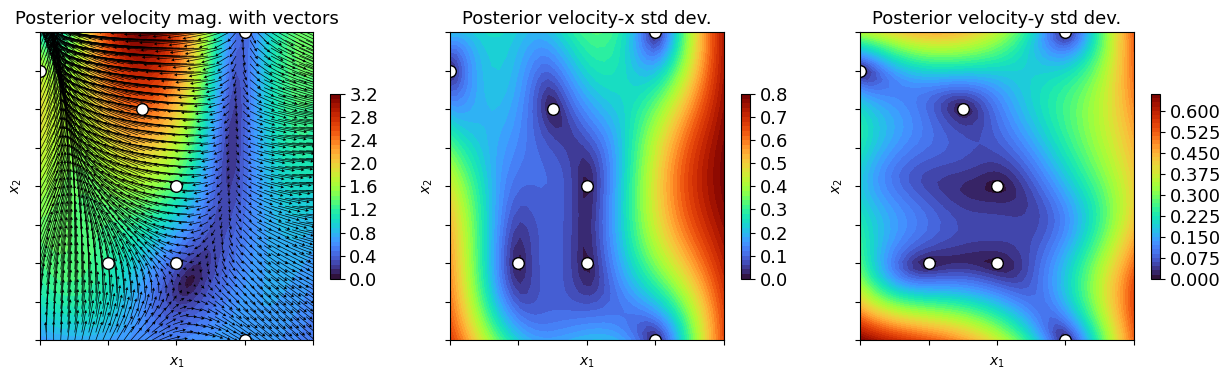

In [19]:
norm = matplotlib.colors.Normalize(vmin=np.min(velocity_mag),\
                                    vmax=np.max(velocity_mag))

fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(131)
c = ax1.contourf(T, S, velocity_mag.reshape(n, m), 50, cmap=plt.cm.turbo, norm=norm)
plt.quiver(Xpred[:,0], Xpred[:,1], velocity_x_mean, velocity_y_mean, headwidth=5, scale=10)
plt.scatter(X_init[0:num_random_points,0], X_init[0:num_random_points,1], c='w', s=70, lw=1, edgecolor='k')
cbar = plt.colorbar(c, pad=0.05, shrink=0.6)
cbar.ax.tick_params(labelsize=13)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
ax1.set_title('Posterior velocity mag. with vectors', fontsize=13)


norm = matplotlib.colors.Normalize(vmin=np.min(velocity_x_std),\
                                    vmax=np.max(velocity_x_std))

ax2 = plt.subplot(132)
c = ax2.contourf(T, S, velocity_x_std.reshape(n, m), 50, cmap=plt.cm.turbo, norm=norm)
plt.scatter(X_init[0:num_random_points,0], X_init[0:num_random_points,1], c='w', s=70, lw=1, edgecolor='k')
cbar = plt.colorbar(c, pad=0.05, shrink=0.6)
cbar.ax.tick_params(labelsize=13)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
ax2.set_title('Posterior velocity-x std dev.', fontsize=13)

norm = matplotlib.colors.Normalize(vmin=np.min(velocity_y_std),\
                                    vmax=np.max(velocity_y_std))

ax3 = plt.subplot(133)
c = ax3.contourf(T, S, velocity_y_std.reshape(n, m), 50, cmap=plt.cm.turbo, norm=norm)
plt.scatter(X_init[0:num_random_points,0], X_init[0:num_random_points,1], c='w', s=70, lw=1, edgecolor='k')
cbar = plt.colorbar(c, pad=0.05, shrink=0.6)
cbar.ax.tick_params(labelsize=13)
ax3.set_yticklabels([])
ax3.set_xticklabels([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
ax3.set_title('Posterior velocity-y std dev.', fontsize=13)
plt.savefig('velocity_curl_free.png', dpi=170, bbox_inches='tight', transparent=True)
plt.show()

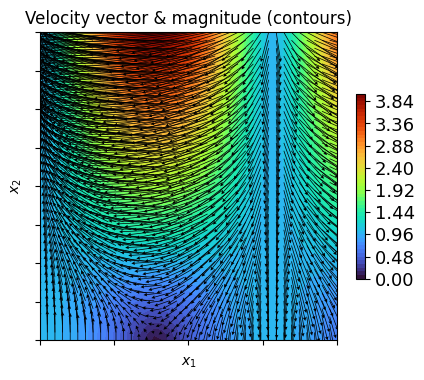

In [21]:
norm = matplotlib.colors.Normalize(vmin=np.min(vel_mag_truth),\
                                    vmax=np.max(vel_mag_truth))

fig = plt.figure(figsize=(4.8,4))
ax1 = plt.subplot()
c = ax1.contourf(T, S, vel_mag_truth.reshape(n, m), 50, cmap=plt.cm.turbo, norm=norm)
plt.quiver(Xpred[:,0], Xpred[:,1], vel_x_truth, vel_y_truth, headwidth=5, scale=10)
cbar = plt.colorbar(c, pad=0.05, shrink=0.6)
cbar.ax.tick_params(labelsize=13)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Velocity vector & magnitude (contours)')
plt.savefig('velocity_true.png', dpi=170, bbox_inches='tight', transparent=True)
plt.show()

## Standard approach -- Independent GPs for each velocity component. 

In [22]:
with pm.Model() as model2:
    
    sigma_f = pm.HalfNormal("sigma_f", sigma=1)
    l = pm.HalfNormal("l", sigma=1.0)
    cov = SquaredExp(2, sigma_f, l)
    gp = pm.gp.Marginal(cov_func=cov)
    y_ = gp.marginal_likelihood("y_", X=X_init[0:num_random_points,:].reshape(num_random_points, 2), \
                                      y=y_init[0:num_random_points] - np.mean(y_init[0:num_random_points]), \
                                      noise=1e-4)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [23]:
with model2:
    mp2 = pm.find_MAP()

Output()

In [24]:
with model2:
    post_mean2, post_covar2 = gp.predict(Xpred, point=mp2, diag=False)

In [25]:
with pm.Model() as model3:
    
    sigma_f = pm.HalfNormal("sigma_f", sigma=1)
    l = pm.HalfNormal("l", sigma=1.0)
    cov = SquaredExp(2, sigma_f, l)
    gp = pm.gp.Marginal(cov_func=cov)
    y_ = gp.marginal_likelihood("y_", X=X_init[0:num_random_points,:].reshape(num_random_points, 2), \
                                      y=y_init[num_random_points:] - np.mean(y_init[num_random_points:]), \
                                      noise=1e-4)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [26]:
with model3:
    mp3 = pm.find_MAP()
    
        
with model3:
    post_mean3, post_covar3 = gp.predict(Xpred, point=mp3, diag=False)

Output()

In [27]:
velocity_x_mean_gp = post_mean2
velocity_y_mean_gp = post_mean3
velocity_mag_mean_gp = np.sqrt(velocity_x_mean_gp**2 + velocity_y_mean_gp**2 )
velocity_x_std_gp = np.sqrt(np.diag(post_covar2))
velocity_y_std_gp = np.sqrt(np.diag(post_covar3))

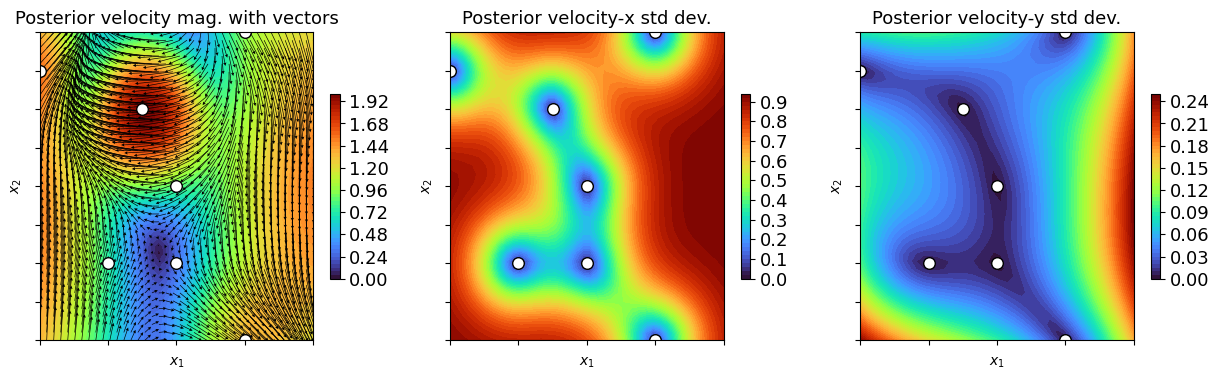

In [29]:
norm = matplotlib.colors.Normalize(vmin=np.min(velocity_mag_mean_gp),\
                                    vmax=np.max(velocity_mag_mean_gp))

fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(131)
c = ax1.contourf(T, S, velocity_mag_mean_gp.reshape(n, m), 50, cmap=plt.cm.turbo, norm=norm)
plt.quiver(Xpred[:,0], Xpred[:,1], velocity_x_mean_gp, velocity_y_mean_gp, headwidth=5, scale=10)
plt.scatter(X_init[0:num_random_points,0], X_init[0:num_random_points,1], c='w', s=70, lw=1, edgecolor='k')
cbar = plt.colorbar(c, pad=0.05, shrink=0.6)
cbar.ax.tick_params(labelsize=13)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
ax1.set_title('Posterior velocity mag. with vectors', fontsize=13)


norm = matplotlib.colors.Normalize(vmin=np.min(velocity_x_std_gp),\
                                    vmax=np.max(velocity_x_std_gp))

ax2 = plt.subplot(132)
c = ax2.contourf(T, S, velocity_x_std_gp.reshape(n, m), 50, cmap=plt.cm.turbo, norm=norm)
plt.scatter(X_init[0:num_random_points,0], X_init[0:num_random_points,1], c='w', s=70, lw=1, edgecolor='k')
cbar = plt.colorbar(c, pad=0.05, shrink=0.6)
cbar.ax.tick_params(labelsize=13)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
ax2.set_title('Posterior velocity-x std dev.', fontsize=13)

norm = matplotlib.colors.Normalize(vmin=np.min(velocity_y_std_gp),\
                                    vmax=np.max(velocity_y_std_gp))

ax3 = plt.subplot(133)
c = ax3.contourf(T, S, velocity_y_std_gp.reshape(n, m), 50, cmap=plt.cm.turbo, norm=norm)
plt.scatter(X_init[0:num_random_points,0], X_init[0:num_random_points,1], c='w', s=70, lw=1, edgecolor='k')
cbar = plt.colorbar(c, pad=0.05, shrink=0.6)
cbar.ax.tick_params(labelsize=13)
ax3.set_yticklabels([])
ax3.set_xticklabels([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
ax3.set_title('Posterior velocity-y std dev.', fontsize=13)
plt.savefig('velocity_gp.png', dpi=170, bbox_inches='tight', transparent=True)
plt.show()

## Debugging below

In [ ]:
sigma_f2 = 0.7767**2
l2 = 1.6295**2

def full(self, X, Xs=None):
    if Xs is None:
        Xs = X
    m = int(X.shape[0]/2)
    n = int(Xs.shape[0]/2)

    X = X[0:m,:]
    Xs = Xs[0:n,:]

    m2 = int( m * 2 )
    n2 = int( n * 2 )

    del_X = get_X_minus_X(X, Xs, 0)
    del_Y = get_X_minus_X(X, Xs, 1)
    del_X2 = del_X**2
    del_Y2 = del_Y**2
    

    K = np.zeros((m2,n2))

    K[0:m, 0:n] = dK_yy(del_X2,del_Y2)
    K[0:m,n:n2] = dK_yx(del_X2,del_Y2, del_X, del_Y)

    K[m:m2,0:n] = dK_yx(del_X2,del_Y2, del_X, del_Y)
    K[m:m2, n:n2] = dK_xx(del_X2,del_Y2)
    
    return K, get_X_minus_X(X, Xs, 0), get_X_minus_X(X, Xs, 1)

def get_X_minus_X(X, Xs, input_dim):
    k, v = X.shape[0], Xs.shape[0]
    M = X[:,input_dim].reshape(k,1)
    Ms = Xs[:,input_dim].reshape(v,1)
    return np.reshape(M, (-1,1)) - np.reshape(Ms, (1,-1))

def dK_xx(del_X2, del_Y2):
    # (sigma_f^2*exp(-(x^2 + y^2)/(2*l^2))*(l^2 - x^2))/l^4
    return (sigma_f2 * \
            np.exp(-(del_X2 + del_Y2)/(2*l2) ) * \
            (l2  - del_X2))/l2**2

def dK_yy(del_X2, del_Y2):
    # (sigma_f^2*exp(-(x^2 + y^2)/(2*l^2))*(l^2 - y^2))/l^4
    return (sigma_f2 * 
            np.exp(-(del_X2 + del_Y2)/(2*l2) ) * \
            (l2 - del_Y2))/l2**2

#def dK_xy(self, del_X2, del_Y2):
#    # - l^4*sigma_f^2*x*y*exp(-(l^2*(x^2 + y^2))/2)
#    return tt.square(self.l2) * self.sigma_f2 * tt.sqrt(del_X2) * tt.sqrt(del_Y2) * \
#            tt.exp(-0.5 * self.l2 * (del_X2 + del_Y2))

def dK_yx(del_X2, del_Y2, del_X, del_Y):
    # (sigma_f^2*x*y*exp(-(x^2 + y^2)/(2*l^2)))/l^4
    return  (sigma_f2 * del_X * del_Y * \
            np.exp(-(del_X2 + del_Y2)/(2*l2)))/l2**2

In [ ]:
K, delX, delY = full(X_init, X_init)

In [ ]:
c = plt.imshow(K)
plt.colorbar(c)

In [ ]:
from scipy.linalg import cholesky

In [ ]:
cholesky(K + 1e-12 * np.eye(K.shape[0]))

In [ ]:
np.savetxt('value.txt', np.around(K, 4))

In [ ]:
np.around(K, 4)

In [ ]:
np.savetxt("foo.csv", K, delimiter=",")